# Semantic Scholar Dataset Curation
In this notebook, we'll explore the possibility of using the `fieldsOfStudy` and `s2FieldsOfStudy` attributes from the S2 API to filter down our dataset to more relevant papers.

In [40]:
import jsonlines
import requests
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from itertools import product

In [2]:
# Import API key. This must be requested from https://www.semanticscholar.org/product/api#api-key; we save ours in an untracked file in data and import here
import sys
sys.path.append('../data/')
from semantic_scholar_API_key import API_KEY
header = {'x-api-key': API_KEY}

## Reading in the data
We'll use the vitrification dataset here, since it has the highest degree of "contamination" with medical and chemistry literature.

In [3]:
with jsonlines.open('../data/semantic_scholar/vitrification_2000_22Nov2023.jsonl') as reader:
    vit = []
    for obj in reader:
        vit.append(obj)

## Getting fields of study
Let's start with just the main search results, not their references:

In [4]:
main_result_pids = [p['paperId'] for p in vit]

In [5]:
len(main_result_pids)

999

In [6]:
with_fields = []
for i in range(2):
    ids = main_result_pids[i*500:(i+1)*500]
    succeeded = False
    while not succeeded:
        r = requests.post(
            'https://api.semanticscholar.org/graph/v1/paper/batch',
            params={'fields': 'title,abstract,year,fieldsOfStudy,s2FieldsOfStudy'},
            json={"ids": ids},
            headers=header
        ).json()
        if type(r) == list:
            succeeded = True
        else:
            print(f'Request number {i} failed, trying again')
    with_fields.extend(r)  

In [7]:
with_fields[0]

{'paperId': '0edd534ccb9179f19583ef3fc416cd609039a387',
 'title': 'Vitrification and Nanowarming of Kidneys',
 'abstract': 'Vitrification can dramatically increase the storage of viable biomaterials in the cryogenic state for years. Unfortunately, vitrified systems ≥3 mL like large tissues and organs, cannot currently be rewarmed sufficiently rapidly or uniformly by convective approaches to avoid ice crystallization or cracking failures. A new volumetric rewarming technology entitled “nanowarming” addresses this problem by using radiofrequency excited iron oxide nanoparticles to rewarm vitrified systems rapidly and uniformly. Here, for the first time, successful recovery of a rat kidney from the vitrified state using nanowarming, is shown. First, kidneys are perfused via the renal artery with a cryoprotective cocktail (CPA) and silica‐coated iron oxide nanoparticles (sIONPs). After cooling at −40 °C min−1 in a controlled rate freezer, microcomputed tomography (µCT) imaging is used to v

## Examining fields of study
### Overall statistics
First, let's look at how many of what kinds of keywords we see in this dataset.

In [8]:
set([f['source'] for p in with_fields for f in p['s2FieldsOfStudy']])

{'external', 's2-fos-model'}

In [9]:
all_externals = []
all_s2 = []
for p in with_fields:
    if p['fieldsOfStudy'] is not None:
        all_externals.extend(p['fieldsOfStudy'])
    s2_fields = [f['category'] for f in p['s2FieldsOfStudy'] if f['source'] == 's2-fos-model']
    all_s2.extend(s2_fields)

In [18]:
Counter(all_externals)

Counter({'Medicine': 755,
         'Biology': 588,
         'Chemistry': 172,
         'Materials Science': 153,
         'Physics': 13,
         'Environmental Science': 8,
         'Computer Science': 7,
         'Geology': 4,
         'Engineering': 4,
         'Psychology': 1,
         'Mathematics': 1,
         'Business': 1})

In [23]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate_from_frequencies(Counter(all_externals))

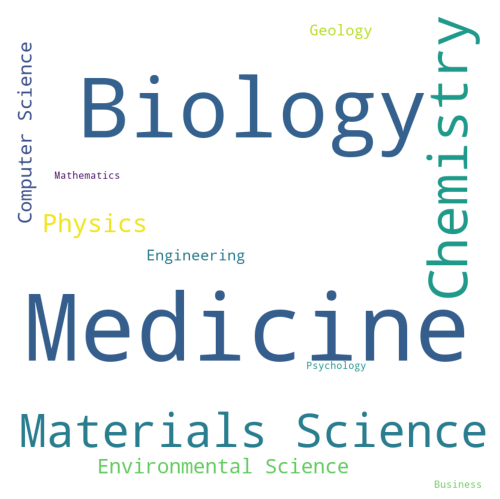

In [24]:
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [25]:
Counter(all_s2)

Counter({'Medicine': 427,
         'Biology': 392,
         'Materials Science': 216,
         'Agricultural and Food Sciences': 181,
         'Environmental Science': 126,
         'Chemistry': 66,
         'Physics': 58,
         'Engineering': 57,
         'Agricultural And Food Sciences': 4,
         'Geology': 4,
         'Economics': 1})

In [26]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate_from_frequencies(Counter(all_s2))

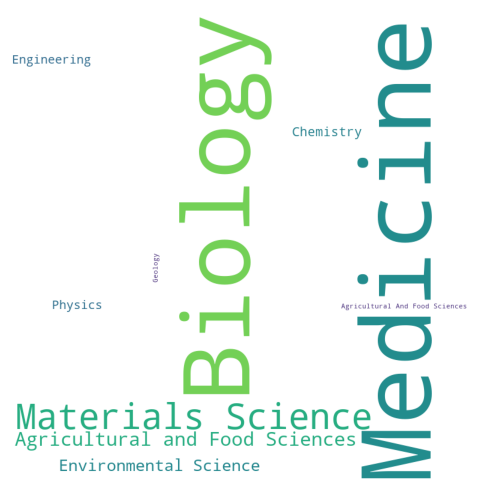

In [27]:
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

How many of the papers have extermal vs. S2 keywords? How many papers have no keywords at all?

In [31]:
both, s2_only, external_only, no_keywords = 0, 0, 0, 0
for p in with_fields:
    has_external = True if (p['fieldsOfStudy'] is not None) and (len(p['fieldsOfStudy']) > 0) else False
    has_s2 = True if len([f['category'] for f in p['s2FieldsOfStudy'] if f['source'] == 's2-fos-model']) > 0 else False
    if has_external and has_s2:
        both += 1
    elif has_external and not has_s2:
        external_only += 1
    elif not has_external and has_s2:
        s2_only += 1
    else:
        no_keywords += 1
print(f'Of the {len(with_fields)} papers, {both} have both types of keywords, {external_only} have only external keywords, {s2_only} have only S2-generated keywords, and {no_keywords} have neither.')

Of the 999 papers, 991 have both types of keywords, 5 have only external keywords, 3 have only S2-generated keywords, and 0 have neither.


Oh hell yeah that is fantastic coverage!

### Comparison of S2 vs. External labels
The S2 labels look more helpful, especially since they have an "Agricultural and food sciences" tag. However, what kinds of labels tend to get assigned to the same papers? To take a look at this, we'll create a little graph, where nodes are the keywords, colored by whether they were external or S2 keywords, and the edges are keywords that were assigned on the same paper. The weight of the edge will be augmented for every time that two keywords are assigned together, which should give us a visual on which keywords appear together how often.

Since there is overlap in the keywords between external sources and S2, we'll make  aunique node for each of them by appending `_ex` or `_s2` to the keyword string (otherwise the node would get overwritten when we add the other attribute); we would expect those keywords to always co-occur together, but it'll be good to confirm that.

In [39]:
all_nodes = []
all_edges = []
for p in with_fields:
    externals = [(k + '_ex', {'source': 'external'}) for k in p['fieldsOfStudy']]
    s2 = [(f['category'] + '_s2', {'source': 's2'}) for f in p['s2FieldsOfStudy'] if f['source'] =='s2-fos-model']
## pick up here

['Medicine'] ['Engineering'] [('Medicine', 'Engineering')]
['Medicine', 'Computer Science'] ['Medicine'] [('Medicine', 'Medicine')]
['Medicine'] ['Biology'] [('Medicine', 'Biology')]


IndexError: list index out of range

### Heuristic evaluation of whether or not these work for filtering
In the end, what we want to be able to do is say, "Exclude all papers with a Medicine tag". But what we need to know before doing that is, how well does that work? How often would we be eliminating papers that we actually want to keep? To get a first idea, let's 